# GrOpt

**GRadient OPTimization Toolbox** - The **GrOpt** toolbox allows for gradient waveforms to be numerically designed subject to gradient hardware, pulse sequence, and other constraints (gradient moments, eddy currents, peripheral nerve stimulation, and more). Therefore, GrOpt enables time-optimal gradient waveform design subject to constraints for which analytical solutions are not feasible. The optimization has been fine-tuned to operate in real-time typically tens of milliseconds, but this depends on the complexity of the problem. GrOpt enables flexible implementation on vendor-agnostic scanner hardware for on-the-fly usage. GrOpt is written in C (for compiling on scanners), with wrappers in Python and Matlab for prototyping.

More info: 
- https://github.com/cmr-group/gropt/tree/master
- https://med.stanford.edu/cmrgroup/software.html
- Loecher M, Middione MJ, Ennis DB. *A gradient optimization toolbox for general purpose time-optimal MRI gradient waveform design*. ***Magn Reson Med***. 2020 Dec;84(6):3234-3245. doi: 10.1002/mrm.28384. https://pubmed.ncbi.nlm.nih.gov/33463724/
- Middione MJ, Loecher M, Moulin K, Ennis DB. *Optimization methods for magnetic resonance imaging gradient waveform design*. ***NMR Biomed***. 2020 Dec;33(12):e4308. doi: 10.1002/nbm.4308. https://pubmed.ncbi.nlm.nih.gov/32342560/

In principal, any gradient waveform can be designed by solving a feasibility problem (meets the constraints) or an optimization problem (amongst feasible solutions find the one that minimizes and objective function). Let's see what it can do!

***Code Authors***: Michael Loecher and Daniel Ennis for Rad229 (May 2025)

In [2]:
# Prepare the environment - Load necessary modules and attempt to compile the GrOpt library if it isn't already
import sys
import numpy as np
import matplotlib.pyplot as plt

# Google Colab -- Get gropt and compile it.
#%%capture # Hides long compile output
#!git clone https://github.com/mloecher/gropt
#%cd gropt/python
#!python setup.py build_ext --inplace

# Personal Laptop -- Add the GrOpt path
sys.path.append('/Users/dbe/Documents/GitHub/gropt/python/')

import gropt
from helper_utils import plot_waveform, get_stim, get_min_TE  # Additional GrOpt related functions

# Display plots inline, directly below the code cell
%matplotlib inline 

### This entire problem demonstrates various ways to design the pre-phasing gradient for an EPI readout.

Calculate the EPI pre-phasing zeroth gradient moment (M0) needed for a specific spatial resolution.

In [3]:
gamma_1H = 42.576e6                # 1H gyromagnetic ratio [Hz/T]
FOV = 0.128                        # Field-of-view [m]
Ny = 128                           # Number of readout samples [#]
delta_k = 1 / FOV                  # ky step size [1/m]
n_ky_start = -Ny // 2              # Index to outermost ky-line [#]
ky_offset = n_ky_start * delta_k   # Outermost ky-line [1/m]
M0_gy = -ky_offset / gamma_1H      # Gradient area need to pre-phase [T•s/m]
M0_gy = M0_gy * 1e3 * 1e3          # M0 pre-phasing gradient area [mT•ms/m]

print(f"M0_gy = {M0_gy:.2f} (mT·ms)/m")

M0_gy = 11.74 (mT·ms)/m


### There exists a nearly infinite number of ways to design a gradient waveform with a specific M0. 

Start with an MRI system with the following gradient hardware specifications:
- G_Max = 45.0 mT/m
- S_Max = 200.0 T/m/s

This is commodity hardware found are a very large number of MRI scanners.

Testing TE = 2.550 1.325 0.713 0.406 0.559 0.483 0.521 0.502 0.492 0.488 0.490 0.491 0.491 Final TE = 0.491 ms
G_max = 44.55 mT/m
S_max = 198.59 T/m/s
PNS_max = 1.34


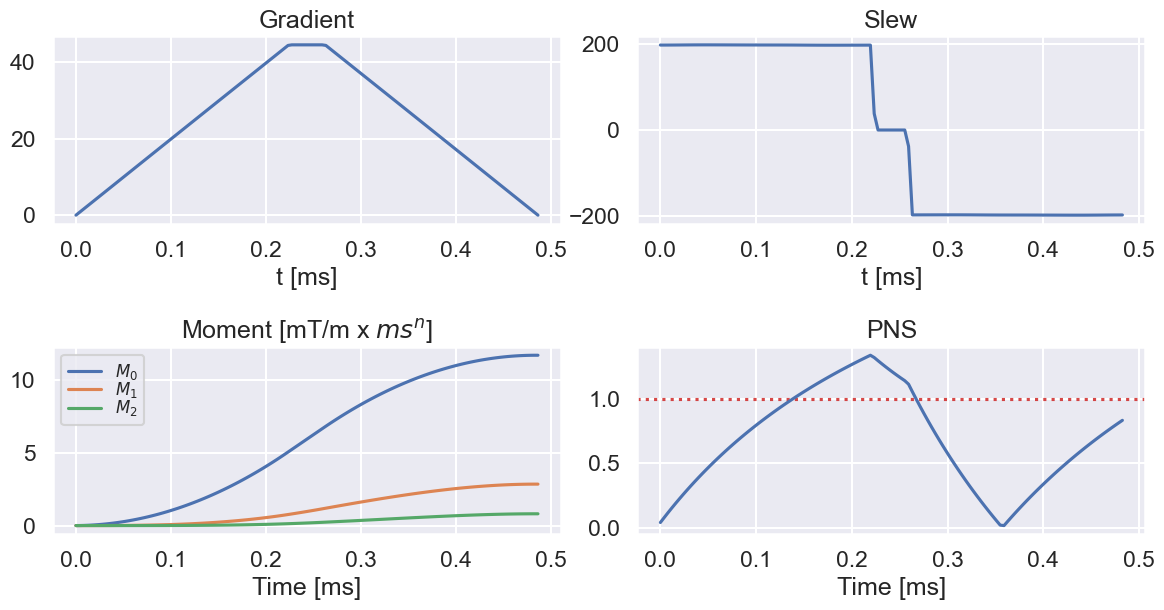

In [ ]:
params = {}
params['mode'] = 'free'  # Free mode indicates we are in a feasibility search, i.e. no objective function
params['dt'] = 4e-6      # Raster time of the gradient waveform being optimized
params['gmax'] = 45.0    # Maximum gradient amplitude, mT/m
params['smax'] = 200.0   # Maximum slew rate, mT/m/ms 
params['max_TE'] = 10.0  # Maximum duration for start of search (not really the TE)
#params['TE'] = 10.0  # Maximum duration for start of search (not really the TE)

# Define gradient waveform moment constraints
# See: https://gropt.readthedocs.io/en/latest/constraints.html
g_axis = 0    # Gradient axis (x=0, y=1, z=2)
g_moment = 0  # Gradient moment
t_offset = 0  # Offset to start of gradient moment calculations
t_start = -1  # -1 means the very beginning of the waveform
t_end = -1    # -1 means the very end of the waveform
g_M0_target = M0_gy      # Gradient moment target [mT•ms ^ (N+1) / m]
g_M0_tol = M0_gy / 1000  # Gradient moment tolerance [mT•ms ^ (N+1) / m]

params['moment_params'] = [[g_axis, g_moment, t_offset, t_start, t_end, g_M0_target, g_M0_tol]]

G, T_min = get_min_TE(params, params['max_TE'], verbose = 1)
#params['TE'] = T_min  # Use the T_Min found from get_min_TE
#G, T_min = gropt.gropt(params)

#G, T_min = gropt.gropt(params)

S = np.diff(G / params['dt'])  # Calculate the slewerate
PNS = get_stim(G, params['dt'])  # Calculate the PNS

print(f"G_max = {np.max(np.abs(G))*1000:.2f} mT/m")
print(f"S_max = {np.max(np.abs(S)):.2f} T/m/s")
print(f"PNS_max = {np.max(np.abs(PNS)):.2f}")
#print('Waveform duration =', round(T_min,3), 'ms')

plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = True, plot_slew = True)

## 1. Gradient maximum, slewrate, and PNS.
#### 1A. Find a slewrate that is sub-threshold for PNS (i.e. for G_max = 45).
- How much longer or shorter is the waveform duration?

- Does the gradient hit the maximum gradient amplitude?

#### 1B. Find a gradient maximum that is sub-threshold for PNS (i.e. for S_max = 200).

- How much longer or shorter is the waveform duration?

- Does the gradient hit the maximum slewrate amplitude?

#### 1C. What is the fundamental limit to the fastest possible gradient waveforms?

Testing TE = 2.550 1.325 0.713 0.406 0.559 0.483 0.521 0.502 0.492 0.488 0.490 0.491 0.491 Final TE = 0.491 ms
G_max = 44.55 mT/m
S_max = 198.59 T/m/s
PNS_max = 1.34
Waveform duration = 0.491 ms


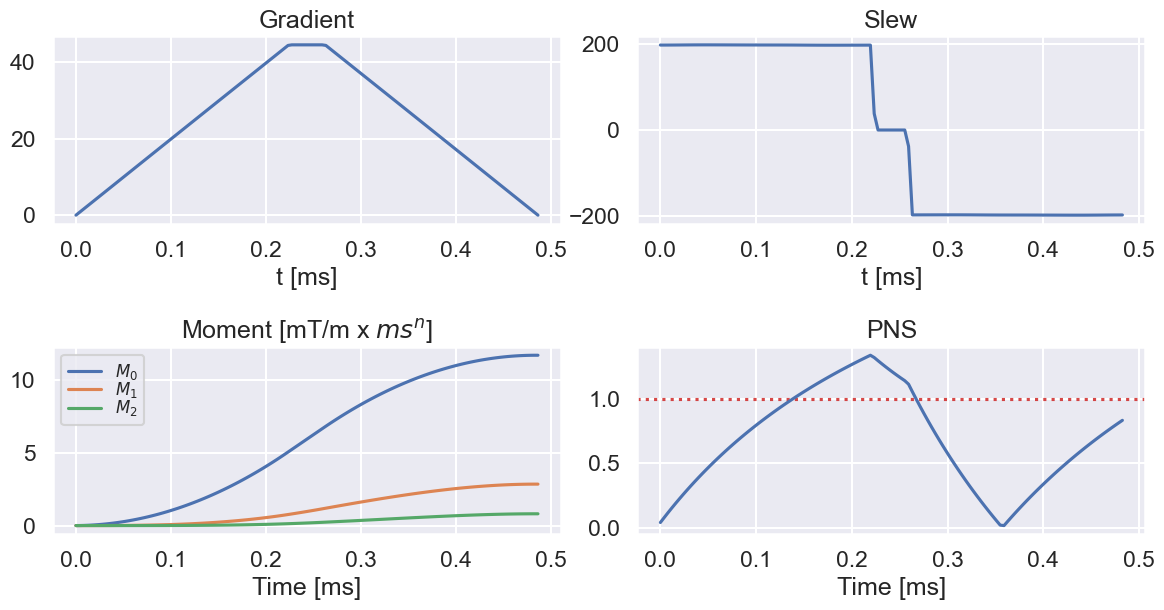

In [ ]:
params = {}
params['mode'] = 'free' # Free mode indicates we are in a feasibility search, i.e. no objective function
params['dt'] = 4e-6     # Raster time of the gradient waveform being optimized
params['gmax'] = 45.0   # Maximum gradient amplitude, mT/m
params['smax'] = 200.0  # Maximum slew rate, mT/m/ms 
params['max_TE'] = 10.0  # Maximum duration for start of search

# Define gradient waveform moment constraints
# See: https://gropt.readthedocs.io/en/latest/constraints.html
g_axis = 0    # Gradient axis (x=0, y=1, z=2)
g_moment = 0  # Gradient moment
t_offset = 0  # Offset to start of gradient moment calculations
t_start = -1  # -1 means the very beginning of the waveform
t_end = -1    # -1 means the very end of the waveform
g_M0_target = M0_gy      # Gradient moment target [mT•ms ^ (N+1) / m]
g_M0_tol = M0_gy / 1000  # Gradient moment tolerance [mT•ms ^ (N+1) / m]

params['moment_params'] = [[g_axis, g_moment, t_offset, t_start, t_end, g_M0_target, g_M0_tol]]

G, T_min = get_min_TE(params, params['max_TE'], verbose = 1)
S = np.diff(G / params['dt'])  # Calculate the slewerate
PNS = get_stim(G, params['dt'])  # Calculate the PNS

print(f"G_max = {np.max(np.abs(G))*1000:.2f} mT/m")
print(f"S_max = {np.max(np.abs(S)):.2f} T/m/s")
print(f"PNS_max = {np.max(np.abs(PNS)):.2f}")
print('Waveform duration =', round(T_min,3), 'ms')

plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = True, plot_slew = True)

## 2. Use GrOpt to add a PNS constraint.
- How do G_max, S_Max, and t_min compare when using GrOpt with a PNS constraint?

Testing TE = 2.550 1.325 0.713 0.406 0.559 0.483 0.521 0.502 0.512 0.507 0.504 0.506 0.506 Final TE = 0.506 ms
G_max = 41.83 mT/m
S_max = 199.18 T/m/s
PNS_max = 1.00
Waveform duration = 0.506 ms


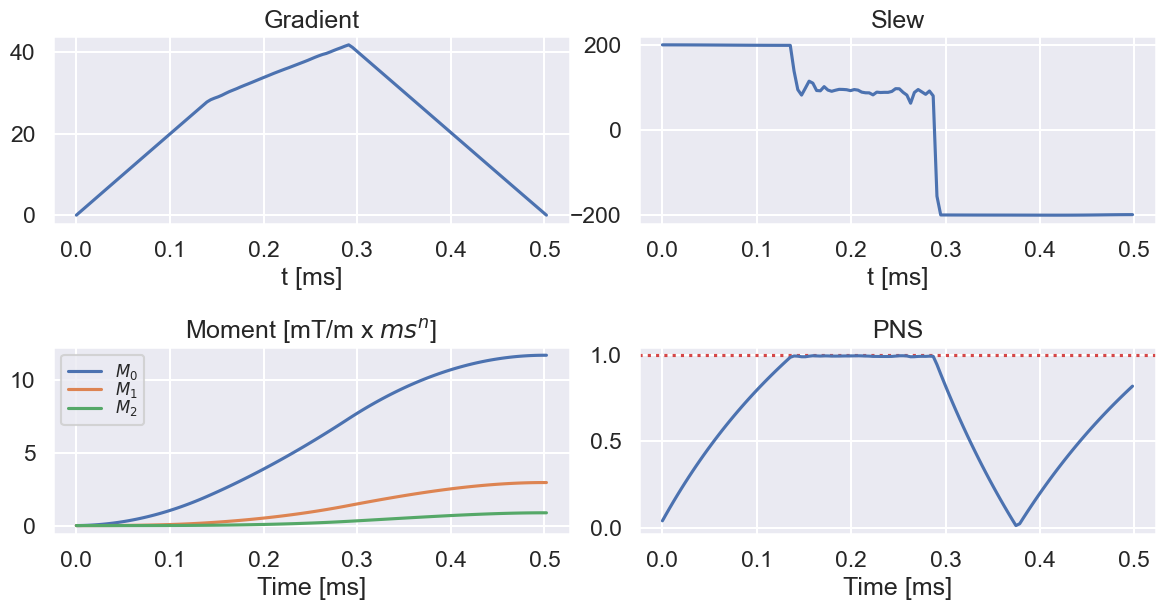

In [ ]:
params = {}
params['mode'] = 'free' # Free mode indicates we are in a feasibility search, i.e. no objective function
params['dt'] = 4e-6     # Raster time of the gradient waveform being optimized
params['gmax'] = 45.0   # Maximum gradient amplitude, mT/m
params['smax'] = 200.0  # Maximum slew rate, mT/m/ms 
params['max_TE'] = 10.0  # Maximum duration for start of search

# Define gradient waveform moment constraints
# See: https://gropt.readthedocs.io/en/latest/constraints.html
g_axis = 0    # Gradient axis (x=0, y=1, z=2)
g_moment = 0  # Gradient moment
t_offset = 0  # Offset to start of gradient moment calculations
t_start = -1  # -1 means the very beginning of the waveform
t_end = -1    # -1 means the very end of the waveform
g_M0_target = M0_gy      # Gradient moment target [mT•ms ^ (N+1) / m]
g_M0_tol = M0_gy / 1000  # Gradient moment tolerance [mT•ms ^ (N+1) / m]

params['moment_params'] = [[g_axis, g_moment, t_offset, t_start, t_end, g_M0_target, g_M0_tol]]

# Add PNS contraint
params['pns_thresh'] = 1.0

G, T_min = get_min_TE(params, params['max_TE'], verbose = 1)
S = np.diff(G / params['dt'])  # Calculate the slewerate
PNS = get_stim(G, params['dt'])  # Calculate the PNS

print(f"G_max = {np.max(np.abs(G))*1000:.2f} mT/m")
print(f"S_max = {np.max(np.abs(S)):.2f} T/m/s")
print(f"PNS_max = {np.max(np.abs(PNS)):.2f}")
print('Waveform duration =', round(T_min,3), 'ms')

plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = True, plot_slew = True)

## 3. Explore what happens on an ultra-high performance system with the following gradient hardware specifications:
- G_Max = 200.0 mT/m
- S_Max = 900.0 T/m/s

Note: The PNS function is specific to each set of hardware gradients. Herein, GrOpt is using a generic form.

#### 3A. Find a slewrate that is sub-threshold for PNS (i.e. for G_max = 200).
- How much longer or shorter is the waveform duration?

- Does the gradient hit the maximum gradient amplitude?

#### 3B. Find a gradient maximum that is sub-threshold for PNS (i.e. for S_max = 900).

- How much longer or shorter is the waveform duration?

- Does the gradient hit the maximum slewrate amplitude?

#### 3C. What happens when you push the resolution to 250µm? Find a slewrate that is sub-threshold for PNS (i.e. for G_max = 200).

- How much longer or shorter is the waveform duration?

- Does the gradient hit the maximum slewrate amplitude?

#### 3D. What happens when you push the resolution to 250µm? Find a gradient maximum that is sub-threshold for PNS (i.e. for S_max = 900).

- How much longer or shorter is the waveform duration?

- Does the gradient hit the maximum slewrate amplitude?


Testing TE = 2.550 1.325 0.713 0.406 0.559 0.483 0.445 0.425 0.416 0.411 0.409 0.410 0.410 Final TE = 0.410 ms
G_max = 46.58 mT/m
S_max = 891.24 T/m/s
PNS_max = 0.99
Waveform duration = 0.41 ms


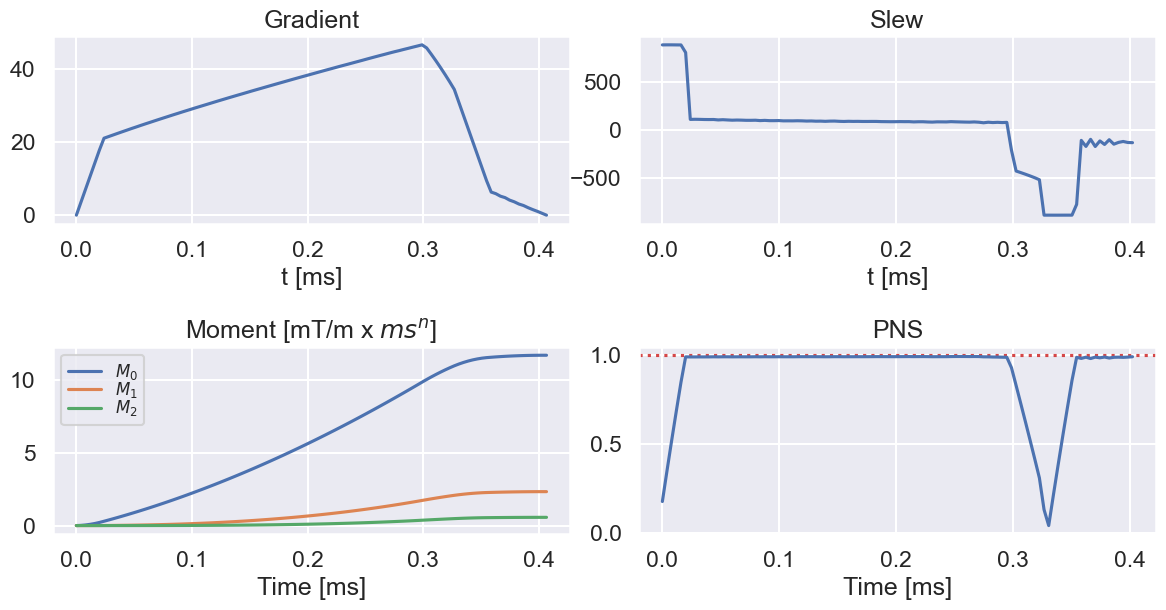

In [22]:
FOV = 0.128                        # Field-of-view [m]
Ny = 128                           # Number of readout samples [#]
delta_k = 1 / FOV                  # ky step size [1/m]
n_ky_start = -Ny // 2              # Index to outermost ky-line [#]
ky_offset = n_ky_start * delta_k   # Outermost ky-line [1/m]
M0_gy = -ky_offset / gamma_1H      # Gradient area need to pre-phase [T•s/m]
M0_gy = M0_gy * 1e3 * 1e3          # M0 pre-phasing gradient area [mT•ms/m]

# Define gradient waveform moment constraints
# See: https://gropt.readthedocs.io/en/latest/constraints.html
g_axis = 0    # Gradient axis (x=0, y=1, z=2)
g_moment = 0  # Gradient moment
t_offset = 0  # Offset to start of gradient moment calculations
t_start = -1  # -1 means the very beginning of the waveform
t_end = -1    # -1 means the very end of the waveform
g_M0_target = M0_gy      # Gradient moment target [mT•ms ^ (N+1) / m]
g_M0_tol = M0_gy / 1000  # Gradient moment tolerance [mT•ms ^ (N+1) / m]

params = {}
params['mode'] = 'free'  # Free mode indicates we are in a feasibility search, i.e. no objective function
params['dt'] = 4e-6      # Raster time of the gradient waveform being optimized
params['gmax'] = 200.0   # Maximum gradient amplitude, mT/m
params['smax'] = 900.0   # Maximum slew rate, mT/m/ms 
params['max_TE'] = 10.0  # Maximum duration for start of search

params['moment_params'] = [[g_axis, g_moment, t_offset, t_start, t_end, g_M0_target, g_M0_tol]]

# Add PNS contraint
params['pns_thresh'] = 1.0

G, T_min = get_min_TE(params, params['max_TE'], verbose = 1)
S = np.diff(G / params['dt'])  # Calculate the slewerate
PNS = get_stim(G, params['dt'])  # Calculate the PNS

print(f"G_max = {np.max(np.abs(G))*1000:.2f} mT/m")
print(f"S_max = {np.max(np.abs(S)):.2f} T/m/s")
print(f"PNS_max = {np.max(np.abs(PNS)):.2f}")
print('Waveform duration =', round(T_min,3), 'ms')

plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = True, plot_slew = True)

## 4. Keep the PNS constraint and add velocity compensation to the waveform (i.e. set an M1=0 constraint)

Testing TE = 5.050 2.575 1.338 1.956 2.266 2.420 2.343 2.382 2.401 2.411 2.415 2.418 2.419 2.418 Final TE = 2.418 ms
G_max = 94.18 mT/m
S_max = 891.24 T/m/s
PNS_max = 0.99
Waveform duration = 2.42 ms


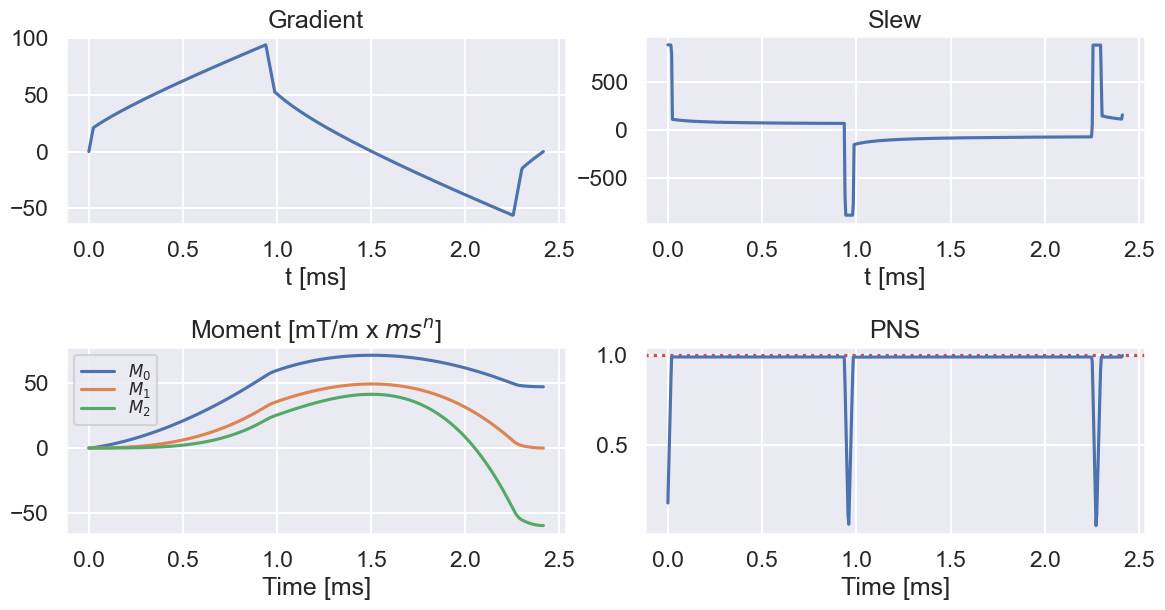

In [23]:
FOV = 0.128                        # Field-of-view [m]
Ny = 512                           # Number of readout samples [#]
delta_k = 1 / FOV                  # ky step size [1/m]
n_ky_start = -Ny // 2              # Index to outermost ky-line [#]
ky_offset = n_ky_start * delta_k   # Outermost ky-line [1/m]
M0_gy = -ky_offset / gamma_1H      # Gradient area need to pre-phase [T•s/m]
M0_gy = M0_gy * 1e3 * 1e3          # M0 pre-phasing gradient area [mT•ms/m]

# Define gradient waveform moment constraints
# See: https://gropt.readthedocs.io/en/latest/constraints.html
g_axis = 0    # Gradient axis (x=0, y=1, z=2)
g_moment = 0  # Gradient moment
t_offset = 0  # Offset to start of gradient moment calculations
t_start = -1  # -1 means the very beginning of the waveform
t_end = -1    # -1 means the very end of the waveform
g_M0_target = M0_gy      # Gradient moment target [mT•ms ^ (N+1) / m]
g_M0_tol = M0_gy / 1000  # Gradient moment tolerance [mT•ms ^ (N+1) / m]

params = {}
params['mode'] = 'free'  # Free mode indicates we are in a feasibility search, i.e. no objective function
params['dt'] = 4e-6      # Raster time of the gradient waveform being optimized
params['gmax'] = 200.0    # Maximum gradient amplitude, mT/m
params['smax'] = 900.0   # Maximum slew rate, mT/m/ms 
params['max_TE'] = 10.0  # Maximum duration for start of search

params['moment_params'] = [[g_axis, g_moment, t_offset, t_start, t_end, g_M0_target, g_M0_tol]]

# Add PNS contraint
params['pns_thresh'] = 1.0

# Add M1 = 0 constraint with a tolerance of 1.0e-3
g_axis = 0    # Gradient axis (x=0, y=1, z=2)
g_moment = 1  # Gradient moment
t_offset = 0  # Offset to start of gradient moment calculations
t_start = -1  # -1 means the very beginning of the waveform
t_end = -1    # -1 means the very end of the waveform
g_M1_target = 0
g_M1_tol = 1e-3

params['moment_params'].append([g_axis, g_moment, t_offset, t_start, t_end, g_M1_target, g_M1_tol])

G, T_min = get_min_TE(params, max_TE = params['max_TE'], verbose = 1)

print(f"G_max = {np.max(np.abs(G))*1000:.2f} mT/m")
print(f"S_max = {np.max(np.abs(S)):.2f} T/m/s")
print(f"PNS_max = {np.max(np.abs(PNS)):.2f}")
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = True, plot_slew = True)